In [1]:
import numpy as np
import spacy
import pandas as pd
import regex as re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from contractions import fix
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import wordnet

Import ag_news dataset

In [2]:
from datasets import load_dataset

# Load the SST-2 dataset from GLUE
dataset = load_dataset("ag_news")

# Print dataset splits
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


In [3]:
df = pd.DataFrame(dataset["train"])


In [4]:
def pos_tagger(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun
    
def clean_text(text, stop_words, lemmatizer):
    text = text.lower().strip()
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove punctuation
    text = re.sub(r"\s+", " ", text)  # Remove extra spaces
    
    word_tokens = word_tokenize(text)  # Tokenize
    filtered_words = [word for word in word_tokens if word not in stop_words]  # Remove stopwords

    # POS tagging
    pos_tagged = nltk.pos_tag(filtered_words)

    # Lemmatize based on POS tags
    lemmatized_words = [lemmatizer.lemmatize(word, pos_tagger(tag)) for word, tag in pos_tagged]

    cleaned_text = " ".join(lemmatized_words)  # Reconstruct text
    return cleaned_text


In [5]:
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english')) #remove stopwords
lemmatizer = WordNetLemmatizer()
df['cleaned_text'] = df['text'].apply(lambda x: clean_text(x, stop_words, lemmatizer))

Perform TF-IDF vectorization

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])
print(X_tfidf.shape)

(120000, 82721)


Apply PCA to reduce dims

In [40]:
print(explained_variance_ratio)

[0.00144015 0.00390342 0.00326372 0.00293532 0.00232919 0.00228753
 0.00217619 0.00189888 0.00185242 0.00178543 0.00168859 0.00167215
 0.00165926 0.00156507 0.00150812 0.00148984 0.00146781 0.00142243
 0.00141005 0.0013787  0.00136024 0.0013235  0.00130209 0.00128531
 0.00127101 0.0012584  0.00122551 0.0012024  0.00118051 0.00116871
 0.00115298 0.00113834 0.00112952 0.00111645 0.0010939  0.00108259
 0.00107248 0.00106694 0.00105344 0.0010512  0.00103169 0.00101787
 0.00100524 0.00100356 0.00099936 0.00099475 0.00098749 0.00098141
 0.00097205 0.00096378 0.00095739 0.00095027 0.00093264 0.00092381
 0.00091471 0.00090631 0.000898   0.00089082 0.00088582 0.00087746
 0.00087142 0.00086628 0.00086336 0.00085083 0.0008448  0.00084198
 0.0008264  0.00081842 0.00081534 0.00081216 0.00081107 0.00080669
 0.00079763 0.00079332 0.00078972 0.00078591 0.00078299 0.00077217
 0.00076961 0.00076761 0.00075963 0.00075692 0.00075081 0.00074595
 0.00074113 0.00073593 0.0007294  0.00072322 0.00072062 0.0007

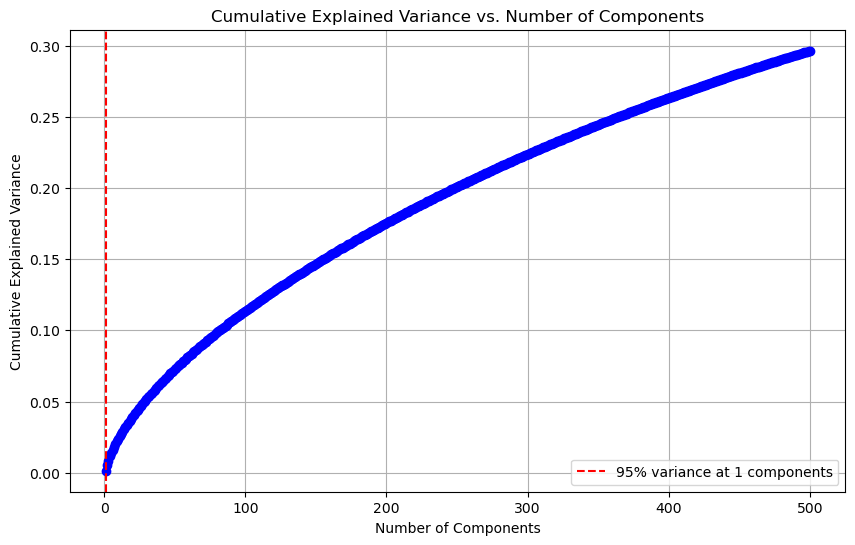

1

In [41]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import numpy as np

# Initialize the TruncatedSVD model with a number of components to be determined
svd = TruncatedSVD(n_components=500)  # Start with 100 components, you can adjust this
X_tfidf_svd = svd.fit_transform(X_tfidf)

# Plot the cumulative explained variance to find the optimal number of components
explained_variance_ratio = svd.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='b')
plt.axvline(x=np.argmax(cumulative_variance >= 0.95) + 1, color='r', linestyle='--', 
            label=f'95% variance at {np.argmax(cumulative_variance >= 0.95) + 1} components')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

# Find the number of components that capture at least 95% of the variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1  # Adding 1 for correct index
n_components_95



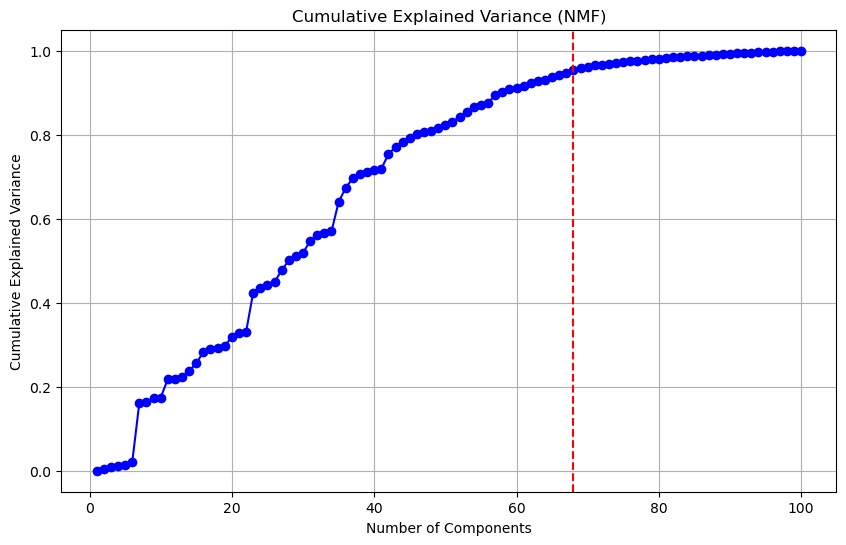

68

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the text (assuming 'df['cleaned_text']' is your cleaned text column)
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])

# Apply NMF
n_components = 100  # Choose the desired number of components
nmf = NMF(n_components=n_components, random_state=1)
X_nmf = nmf.fit_transform(X_tfidf)

# Calculate the singular values for explained variance
# This approximation comes from the squared singular values, similar to PCA
explained_variance = np.square(nmf.components_).sum(axis=1)

# Normalize the explained variance (to get the percentage)
explained_variance_percentage = explained_variance / explained_variance.sum()

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_percentage)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), cumulative_variance, marker='o', linestyle='-', color='b')
plt.axvline(x=np.argmax(cumulative_variance >= 0.95) + 1, color='r', linestyle='--', 
            label=f'95% variance at {np.argmax(cumulative_variance >= 0.95) + 1} components')
plt.title('Cumulative Explained Variance (NMF)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Find the number of components that capture at least 95% of the variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1  # Adding 1 for correct index
n_components_95


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
n_components = 68# Choose the desired number of components
nmf = NMF(n_components=n_components, random_state=1)
X_nmf = nmf.fit_transform(X_tfidf)

Part 2

In [9]:
df

,text,label,cleaned_text
0,Wall St. Bears Claw Back Into the Black (Reute...,2,wall st bear claw back black reuters reuters s...
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,carlyle look toward commercial aerospace reute...
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,oil economy cloud stock outlook reuters reuter...
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,iraq halt oil export main southern pipeline re...
4,"Oil prices soar to all-time record, posing new...",2,oil price soar alltime record pose new menace ...
...,...,...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...,0,pakistan musharraf say wont quit army chief ka...
119996,Renteria signing a top-shelf deal Red Sox gene...,1,renteria sign topshelf deal red sox general ma...
119997,Saban not going to Dolphins yet The Miami Dolp...,1,saban go dolphin yet miami dolphin put courtsh...
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...,1,today nfl game pittsburgh ny giant time pm lin...


In [10]:
X=X_nmf
y=df['label']

In [11]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(
    n_estimators=100,  # Number of boosting rounds
    max_depth=6,       # Maximum depth of trees
    learning_rate=0.1, # Learning rate
    objective='multi:softmax', # For multiclass classification
    num_class=4,       # Number of classes (adjust to 4 for AG News)
    random_state=42
)

# Train the classifier
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Display classification report
print(classification_report(y_test, y_pred, target_names=[str(i) for i in range(4)]))

Accuracy: 86.77%
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      5956
           1       0.91      0.95      0.93      6058
           2       0.84      0.83      0.83      5911
           3       0.85      0.83      0.84      6075

    accuracy                           0.87     24000
   macro avg       0.87      0.87      0.87     24000
weighted avg       0.87      0.87      0.87     24000

